In [1]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension('collapsible_headings/main') 

<IPython.core.display.Javascript object>

In [2]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Import datasets
from doubt.datasets import (Airfoil, Blog, Concrete, CPU, 
                            FacebookComments, FishBioconcentration,
                            FishToxicity, ForestFire, NewTaipeiHousing,
                            PowerPlant, Protein, Servo,
                            SpaceShuttle, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import warnings
from collections import defaultdict
%matplotlib inline
from matplotlib import rcParams
plt.style.use('seaborn-whitegrid')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

# Import internal classes
from distributions import DistributionShift
from src.psi import psi
from tqdm.notebook import tqdm

In [3]:
from xgboost import XGBRegressor
from tabulate import tabulate

In [4]:
dataset_classes = [
    Airfoil,
    Concrete,
    FishToxicity,
    ForestFire,
    NewTaipeiHousing,
    PowerPlant,
    Protein,
    Servo,
]

In [5]:
for dataset in dataset_classes:
    print(dataset().shape)

(1503, 6)
(1030, 9)
(908, 7)
(517, 13)
(414, 7)
(9568, 5)
(45730, 10)
(167, 5)


In [6]:
def initialise_plot(
    num_rows: int, num_cols: int, base_regressor: type, dataset
):
    fig, axs = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        sharey=True,
        figsize=(14, 3.5 * num_rows),
    )
    fig.suptitle(
        f"Monitoring plot for the {dataset.__name__} dataset under feature drift with {base_regressor.__name__}",
        fontsize=16,
    )
    for j in range(num_cols):
        axs[num_rows - 1, j].set_xlabel("Sorted columnd index")
    for i in range(num_rows):
        axs[i, 0].set_ylabel("Normalised values")
    return fig, axs

In [7]:
def kol_smi(x):
    return ks_2samp(x, BASE_COMP).statistic
def psi_stat(x):
    return psi(x, BASE_COMP)

In [8]:
def monitoring_plot(dataset, base_regressor: type, n_boots: int = 20, **kwargs):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Initialise the scaler
        standard_scaler = StandardScaler()

        # Load the dataset and split it
        X, _, y, _ = dataset().split(test_size=0.001, random_seed=4242)

        # Scale the dataset
        X = standard_scaler.fit_transform(X)

        # Back to dataframe
        X = pd.DataFrame(X, columns=["Var %d" % (i + 1) for i in range(X.shape[1])])
        data = X.copy()
        data["target"] = y

        # Train test splitting points
        fracc = 0.33
        oneThird = int(data.shape[0] * fracc)
        twoThird = data.shape[0] - int(data.shape[0] * fracc)
        print(
            "Number of rows {}, 1split {}, 2nd split {}".format(
                data.shape[0], oneThird, twoThird
            )
        )

        # Initialize plots
        num_rows = X.shape[1] // 3
        if X.shape[1] % 3 > 0:
            num_rows += 1
        fig, axs = initialise_plot(
            num_rows=num_rows,
            num_cols=3,
            base_regressor=base_regressor,
            dataset=dataset,
        )

        uncertainty_res = []
        ks_res = []
        psi_res = []
        for idx, col in tqdm(enumerate(X.columns), total=len(X.columns)):
            values = defaultdict(list)

            # Sort data on the column
            data = data.sort_values(col).reset_index(drop=True).copy()

            # Train Test Split
            data_sub = data.iloc[:oneThird]
            data_train = data.iloc[oneThird:twoThird]
            data_up = data.iloc[twoThird:]

            X_tot = data.drop(columns="target")
            X_tr = data_train.drop(columns="target")
            X_sub = data_sub.drop(columns="target")
            X_up = data_up.drop(columns="target")

            y_tot = data[["target"]].target.values
            y_tr = data_train[["target"]].target.values
            y_sub = data_sub[["target"]].target.values
            y_up = data_up[["target"]].target.values

            # Fit the regressor
            regressor = Boot(base_regressor(**kwargs))
            regressor.fit(X_tr, y_tr, n_boots=20)

            # Predictions
            preds, intervals = regressor.predict(
                X_tot, uncertainty=0.05, n_boots=n_boots
            )
            # pre
            d_sub, interval_sub = regressor.predict(
                X_sub.values.astype(object), uncertainty=0.05, n_boots=n_boots
            )
            # pred_up, interval_up = regressor.predict(X_up, uncertainty=0.05, n_boots=n_boots)
            # pred_tr, interval_tr = regressor.predict(X_tr, uncertainty=0.05, n_boots=n_boots)
            # print("Sub:", np.round(mean_absolute_error(y_sub, pred_sub), decimals=2))
            # print("train:", np.round(mean_absolute_error(y_tr, pred_tr), decimals=2))
            # print("up:", np.round(mean_absolute_error(y_up, pred_up), decimals=2))
            # print("total:", np.round(mean_absolute_error(y_tot, preds), decimals=2))

            # print("Sub Uncertainty:", np.round(np.mean(interval_sub[:, 1] - interval_sub[:, 0]), decimals=2))
            # print("tr Uncertainty:", np.round(np.mean(interval_tr[:, 1] - interval_tr[:, 0]), decimals=2))
            # print("Up Uncertainty:", np.round(np.mean(interval_up[:, 1] - interval_up[:, 0]), decimals=2))
            # print("Total Uncertainty:", np.round(np.mean(intervals[:, 1] - intervals[:, 0]), decimals=2))

            # Statistics
            df = pd.DataFrame(
                intervals[:, 1] - intervals[:, 0], columns=["uncertainty"]
            )
            df["error"] = np.abs(preds - y_tot)

            # Rolling window
            ROLLING_STAT = int(df.shape[0] * 0.01)  ### WARNING ON THIS PARAMETER ###
            if ROLLING_STAT < 100:
                ROLLING_STAT = 100

            ### KS Test
            df["ks"] = data[col]
            global BASE_COMP
            BASE_COMP = data[col]
            df[["ks"]] = (
                df[["ks"]]
                .rolling(ROLLING_STAT * 2, int(ROLLING_STAT * 0.5))
                .apply(kol_smi)
            )  # Takes ages
            ### PSI Test
            df["PSI"] = data[col]
            df[["PSI"]] = (
                df[["PSI"]]
                .rolling(ROLLING_STAT * 2, int(ROLLING_STAT * 0.5))
                .apply(psi_stat)
            )  # Takes ages

            ### Rolling window on all
            df[df.columns[~df.columns.isin(["ks", "PSI"])]] = (
                df[df.columns[~df.columns.isin(["ks", "PSI"])]]
                .rolling(ROLLING_STAT, int(ROLLING_STAT * 0.5))
                .mean()
            ).dropna()

            ## Scaling
            df = df.dropna()
            df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)

            # Convert to dic for plotting
            for index, col in enumerate(df.columns):
                values[col] = df[col]

            uncertainty_res.append(
                mean_absolute_error(values["error"], values["uncertainty"])
            )
            ks_res.append(mean_absolute_error(values["error"], values["ks"]))
            psi_res.append(mean_absolute_error(values["error"], values["PSI"]))

            # Plotting
            for name, vals in values.items():
                if idx == 0:
                    axs[idx // 3, idx % 3].plot(vals, label=f"{name} values")
                else:
                    axs[idx // 3, idx % 3].plot(vals)
        resultados = pd.DataFrame({"uncertainy": uncertainty_res, "ks": ks_res,'psi':psi_res})
        resultados.loc["mean"] = resultados.mean()
        print(resultados.to_string())

        fig.legend()
        # plt.savefig("fig.png")
        plt.show()

Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.670360  0.352089  0.629567
1       0.443990  1.122966  1.012187
2       0.683111  0.522469  0.978591
3       0.885328  1.096277  1.030768
4       0.805876  0.738446  0.571712
mean    0.697733  0.766449  0.844565


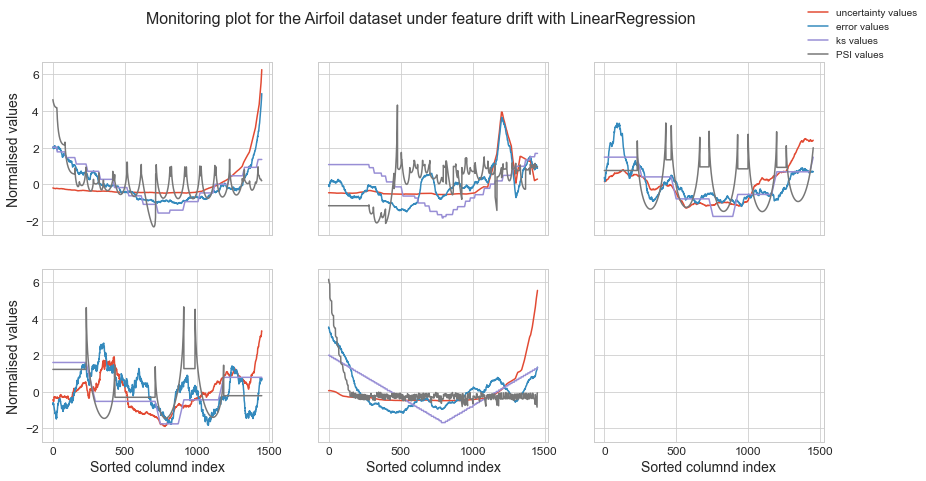

Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.578763  0.921923  1.073541
1       0.455708  0.695903  0.639231
2       0.253478  1.038830  1.282468
3       0.533098  0.391809  0.473948
4       0.484195  0.596974  0.993253
5       0.876486  0.915267  0.836801
6       0.223038  0.554707  0.437377
7       0.903658  0.338486  0.489559
mean    0.538553  0.681737  0.778272


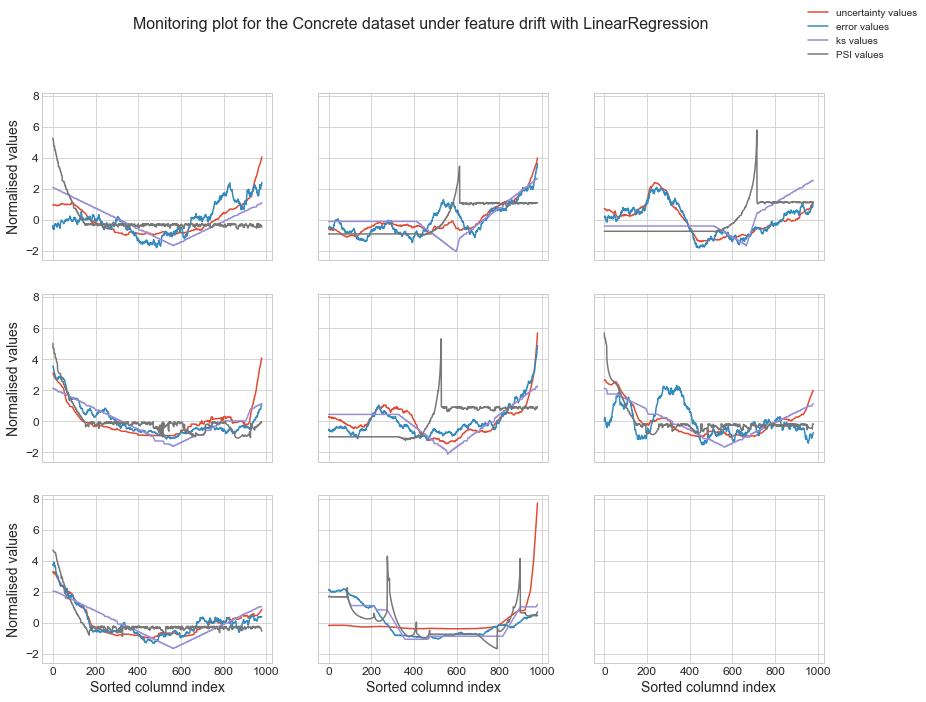

Number of rows 906, 1split 298, 2nd split 608


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.377886  0.702512  0.574981
1       0.770895  0.849162  1.049385
2       1.321127  1.306973  1.122078
3       0.622640  0.709268  0.652292
4       0.536789  0.637682  0.578713
5       0.348580  0.262268  0.656006
mean    0.662986  0.744644  0.772242


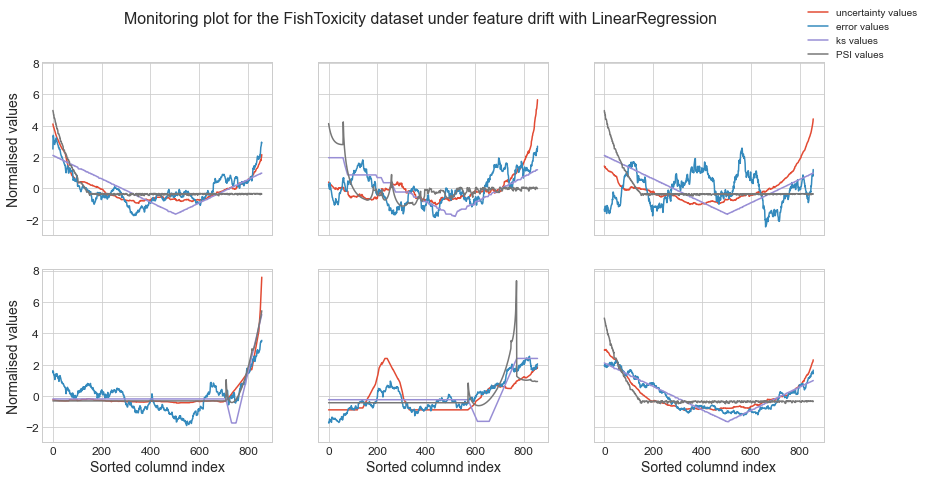

Number of rows 516, 1split 170, 2nd split 346


  0%|          | 0/12 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.879973  1.371291  1.223822
1       0.617338  0.731073  0.591844
2       1.092218  1.282579  1.336221
3       1.211240  1.065814  1.106095
4       0.128456  0.508853  0.206987
5       0.144002  0.464412  0.263901
6       0.153750  0.563878  0.228458
7       0.728525  0.944096  0.751463
8       0.900300  1.101222  0.966894
9       0.572535  0.513308  0.382482
10      0.504075  1.412540  1.205712
11      1.350027  1.016878  0.979150
mean    0.690203  0.914662  0.770253


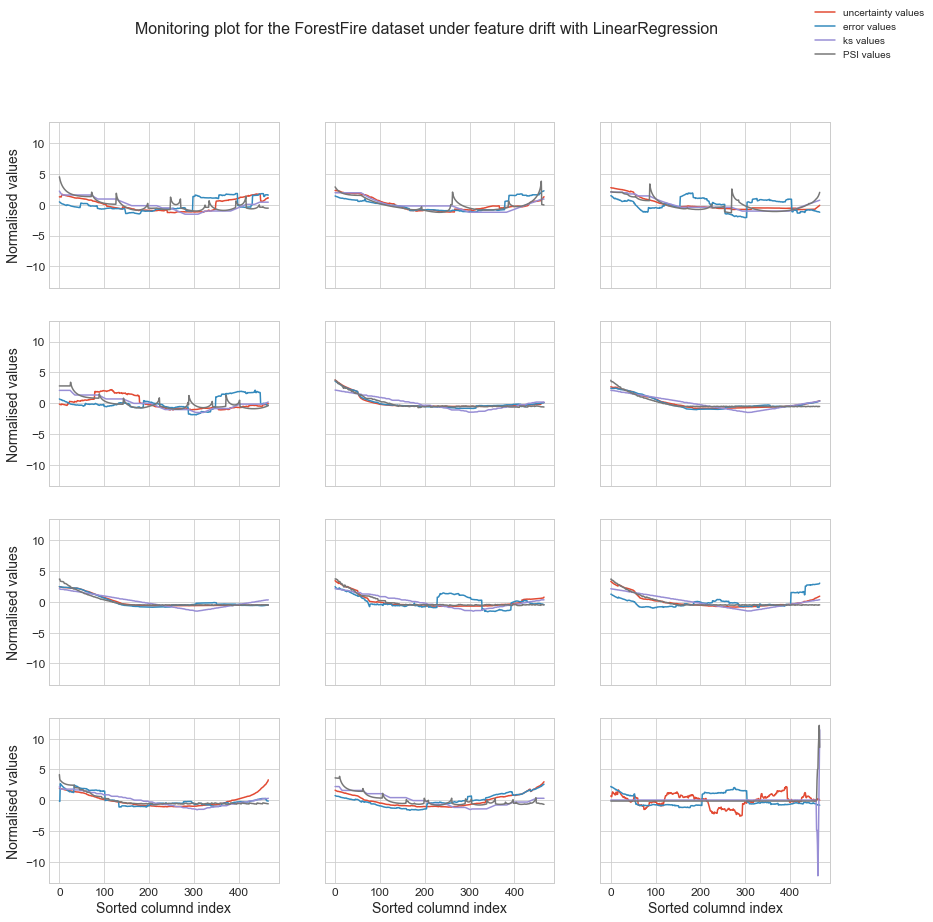

Number of rows 413, 1split 136, 2nd split 277


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       1.329718  1.499574  1.327292
1       0.571470  0.550248  0.723540
2       0.264836  1.042675  0.875552
3       0.238464  0.379830  0.358480
4       0.065114  0.425278  0.111176
5       0.068787  0.457996  0.107211
mean    0.423065  0.725933  0.583875


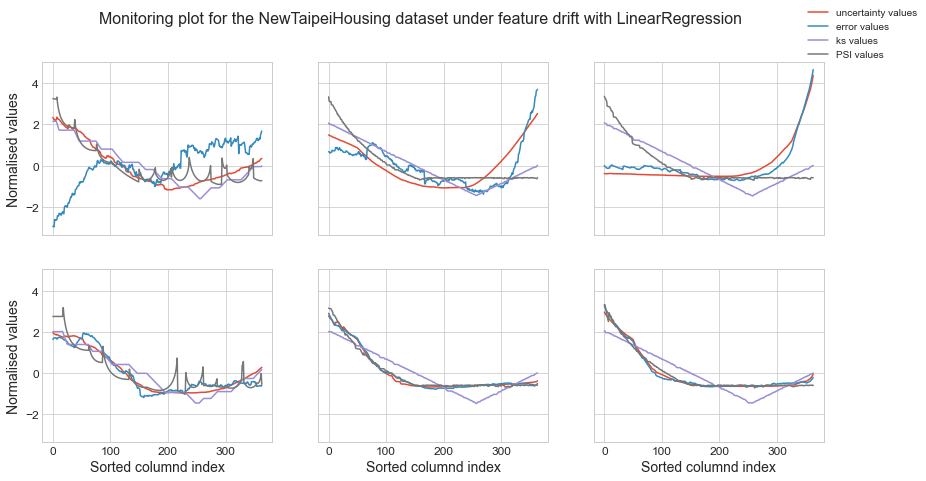

Number of rows 9556, 1split 3153, 2nd split 6403


  0%|          | 0/4 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.932725  0.462506  0.816376
1       1.211279  0.826488  0.992329
2       0.955038  0.963009  0.894350
3       0.896423  0.892098  0.892845
mean    0.998866  0.786025  0.898975


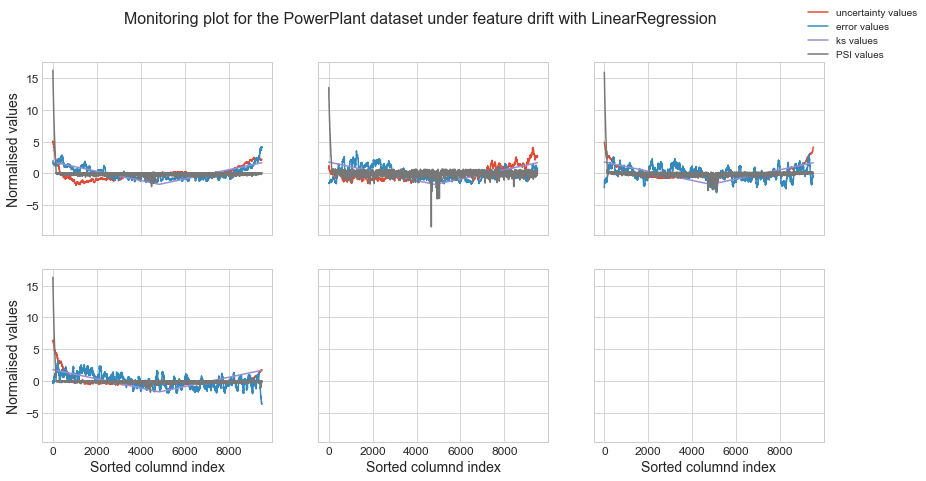

Number of rows 45675, 1split 15072, 2nd split 30603


  0%|          | 0/9 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.529692  0.845162  0.723771
1       0.645065  0.803840  0.656074
2       1.139993  1.277815  0.898317
3       1.112999  1.417192  0.921388
4       0.511570  0.773110  0.721482
5       0.901475  1.042246  0.849281
6       0.600174  0.940391  0.698360
7       0.636862  0.887593  0.815281
8       0.861134  0.923764  0.734322
mean    0.770996  0.990124  0.779808


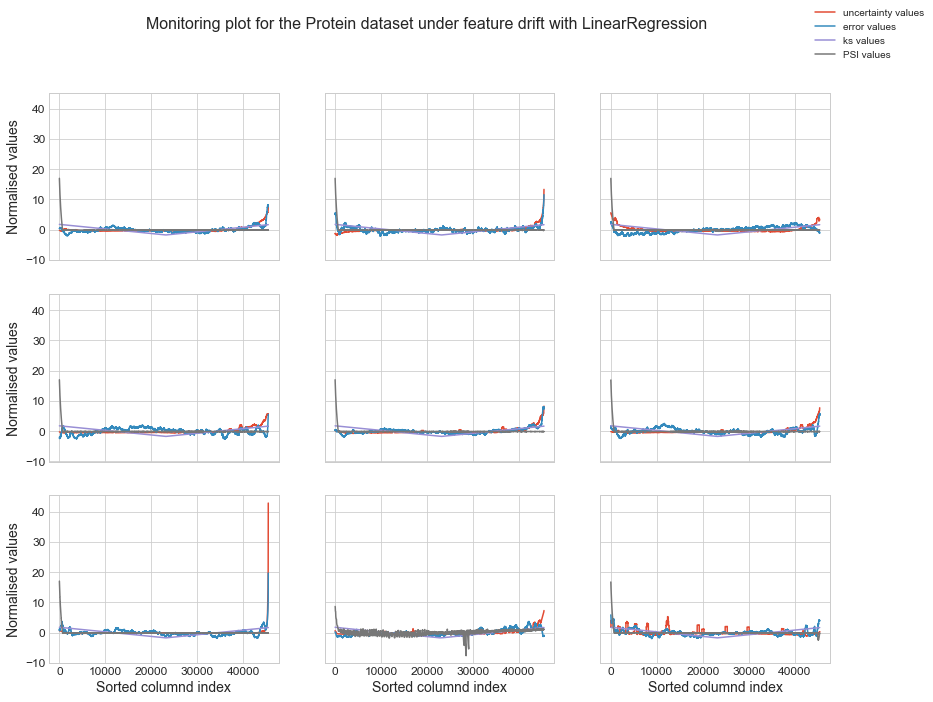

Number of rows 167, 1split 55, 2nd split 112


  0%|          | 0/4 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       1.050801  0.305329  0.630014
1       0.486375  0.226198  0.484412
2       1.585690  0.266913  0.547340
3       0.145736  1.400387  1.193390
mean    0.817150  0.549707  0.713789


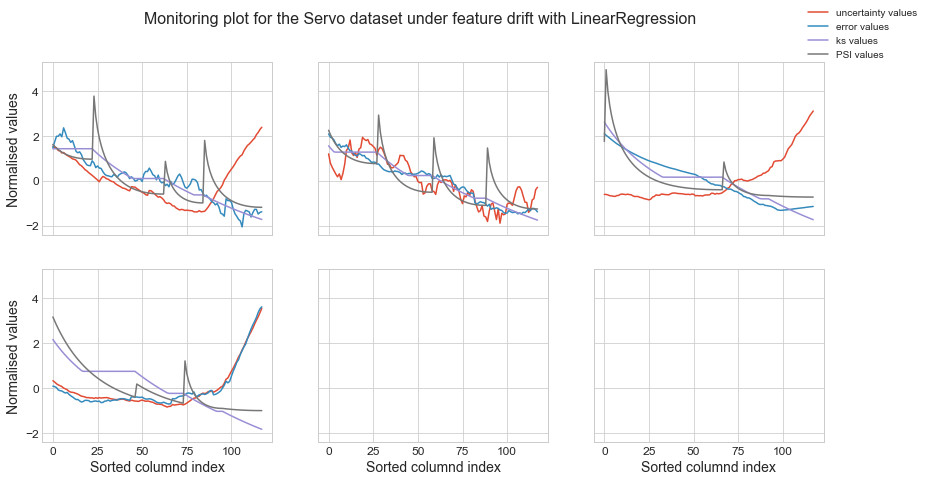

In [9]:
for dataset in dataset_classes:
    monitoring_plot(dataset, LinearRegression)

Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.680648  0.260305  0.749286
1       0.364050  0.578112  1.323955
2       0.315941  0.477334  1.006846
3       0.346658  0.787299  1.222673
4       0.340386  0.477266  1.055393
mean    0.409537  0.516063  1.071630


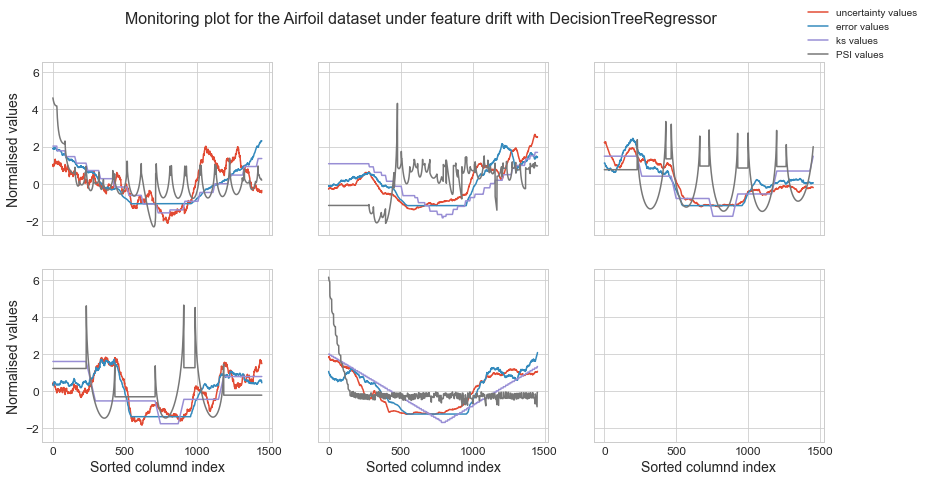

Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.273939  0.478555  1.008275
1       0.286875  0.672704  1.137822
2       0.241088  0.884786  1.092327
3       0.382447  0.522769  0.984113
4       0.214272  0.492373  1.314972
5       0.396823  0.318669  0.921478
6       0.327376  0.328317  0.884190
7       0.833482  0.352666  0.525703
mean    0.369538  0.506355  0.983610


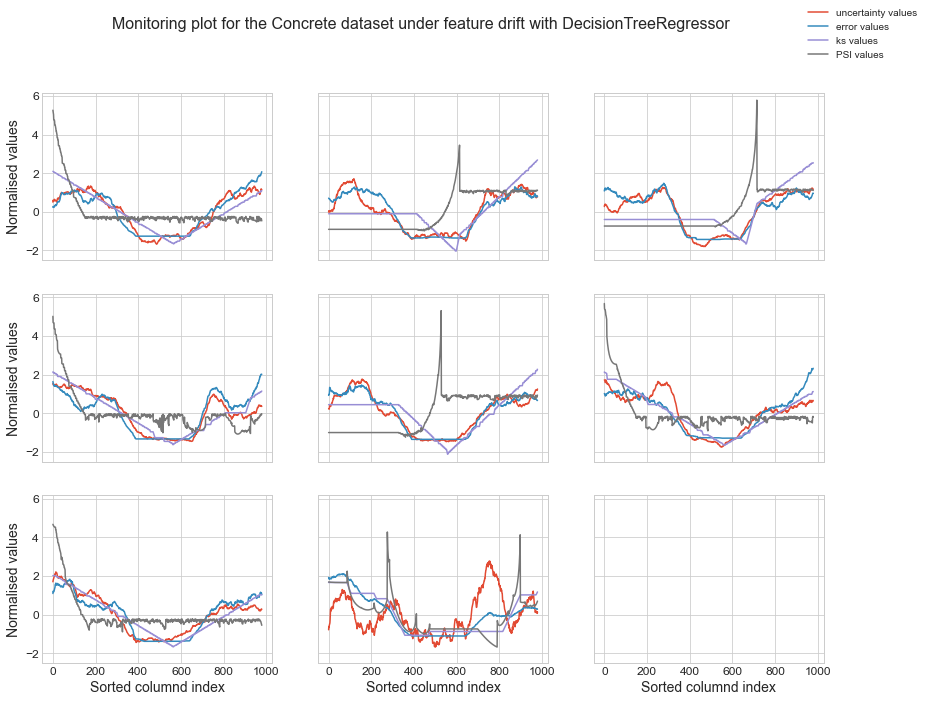

Number of rows 906, 1split 298, 2nd split 608


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.421077  0.398269  0.979486
1       0.362510  0.458796  1.046354
2       0.888045  0.311981  0.862461
3       0.544808  0.998570  0.932435
4       0.332456  0.876453  0.833080
5       0.304624  0.337631  0.862899
mean    0.475587  0.563616  0.919452


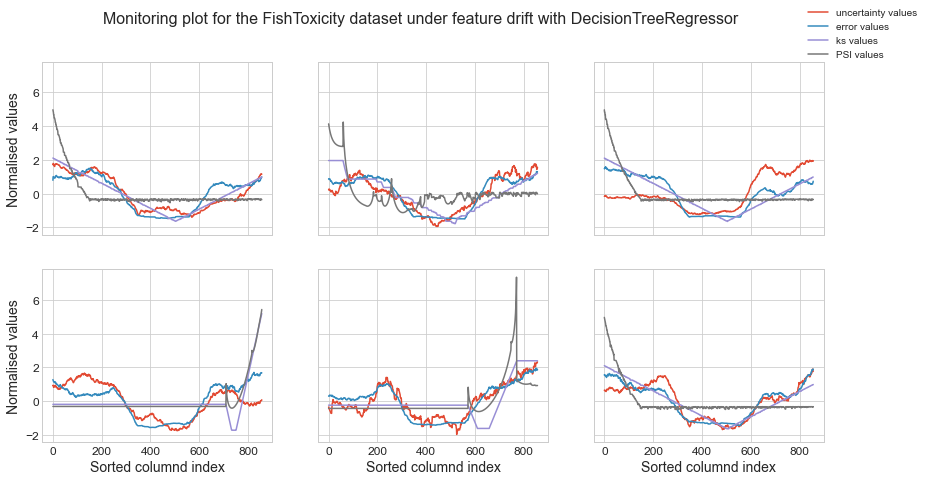

Number of rows 516, 1split 170, 2nd split 346


  0%|          | 0/12 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.493436  1.058446  1.003729
1       0.802584  0.894782  0.694001
2       0.687896  1.160225  1.228471
3       0.821515  0.759876  1.058200
4       0.820905  0.677487  0.934730
5       0.235126  1.216264  1.116614
6       0.773572  1.209758  1.104783
7       1.392942  0.788124  1.072657
8       0.930450  1.005738  1.032196
9       1.054180  0.479306  0.599471
10      0.175482  1.365232  1.210659
11      0.547228  0.965887  0.942954
mean    0.727943  0.965094  0.999872


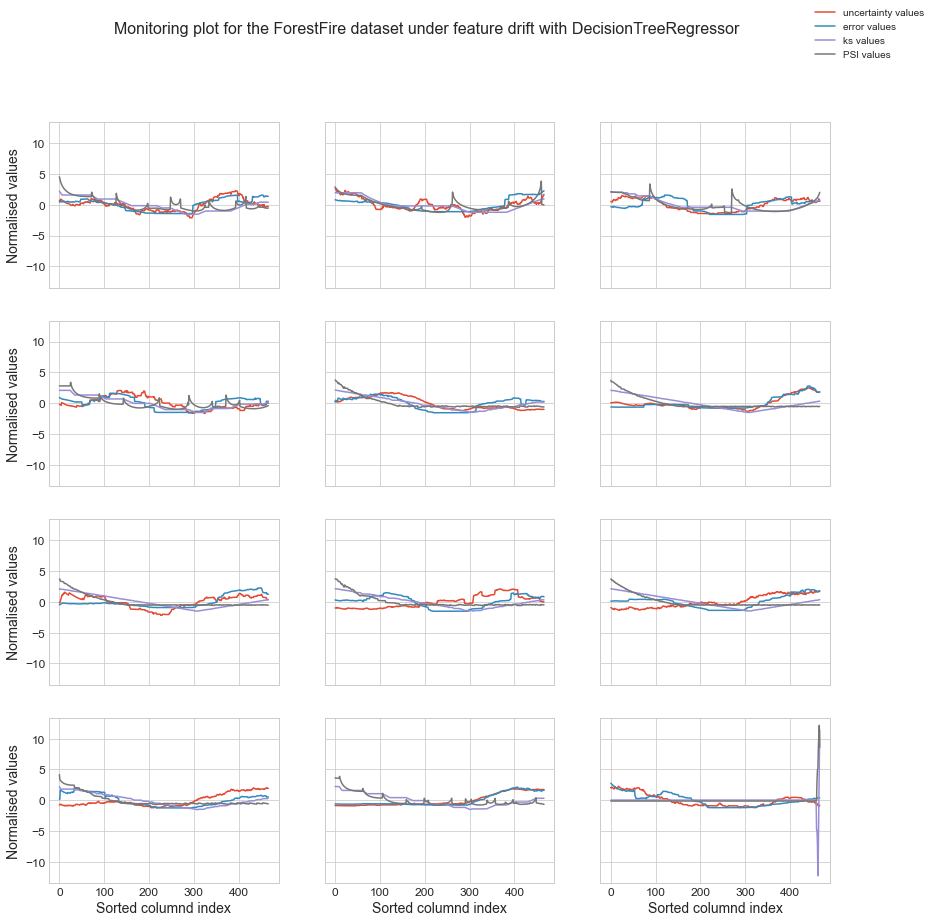

Number of rows 413, 1split 136, 2nd split 277


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.764894  0.756253  0.811110
1       0.216272  0.324252  0.468304
2       0.616542  0.802143  0.864026
3       0.297292  1.001122  0.891601
4       0.294253  1.349415  1.180559
5       0.457125  0.609951  0.627870
mean    0.441063  0.807189  0.807245


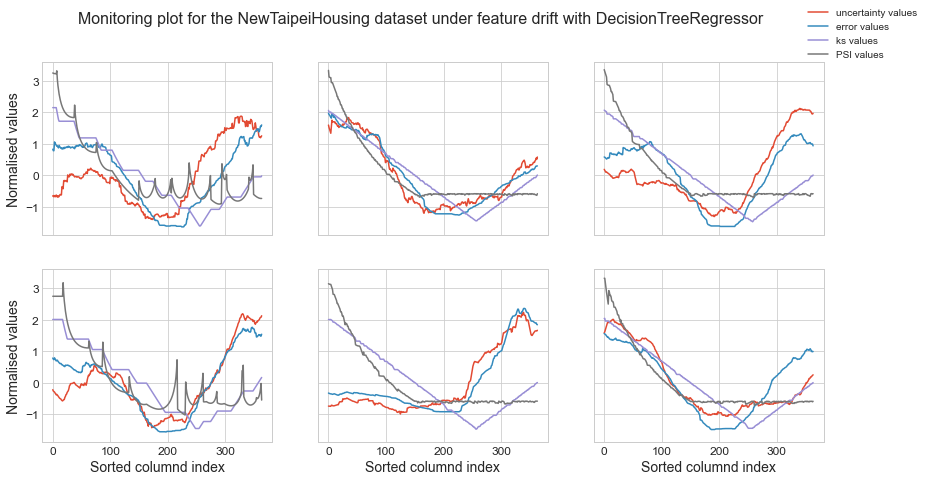

Number of rows 9556, 1split 3153, 2nd split 6403


  0%|          | 0/4 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.613517  0.395220  0.755068
1       0.339467  0.495624  1.037605
2       0.299281  0.418597  0.959796
3       0.346646  0.360478  0.999730
mean    0.399728  0.417480  0.938050


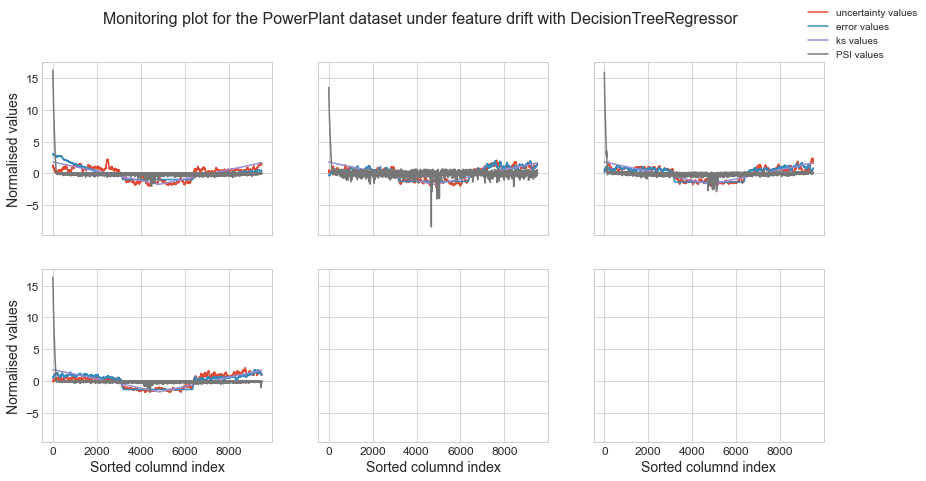

Number of rows 45675, 1split 15072, 2nd split 30603


  0%|          | 0/9 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.441796  0.445046  1.025000
1       0.338592  0.397061  1.012874
2       0.171139  0.323195  0.986289
3       0.345575  0.475649  0.949051
4       0.419954  0.477603  1.047379
5       0.232277  0.474248  0.953966
6       0.408817  0.522517  1.004572
7       0.298835  0.412003  0.874253
8       0.188522  0.435144  0.976153
mean    0.316167  0.440274  0.981060


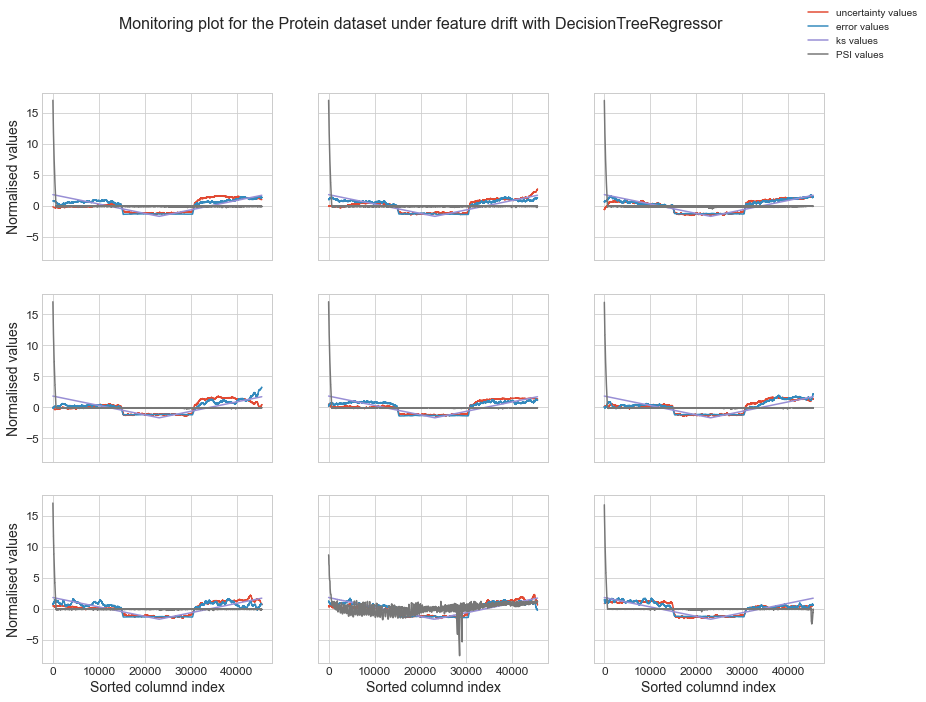

Number of rows 167, 1split 55, 2nd split 112


  0%|          | 0/4 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.887068  1.642561  1.392761
1       1.353762  0.226083  0.465834
2       0.652856  0.255372  0.546144
3       0.886234  0.535602  0.373947
mean    0.944980  0.664905  0.694671


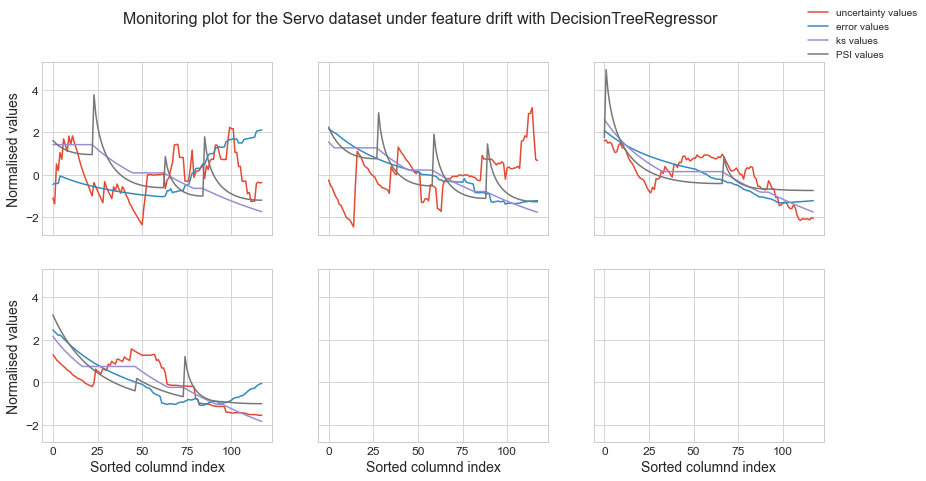

In [10]:
for dataset in dataset_classes:
    monitoring_plot(dataset, DecisionTreeRegressor,max_depth=20)
    #monitoring_plot(dataset,RandomForestRegressor)



Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.662895  0.258074  0.722731
1       0.358305  0.728919  1.201538
2       0.408926  0.439886  1.015557
3       0.768611  0.758807  1.200352
4       0.514702  0.447140  0.908507
mean    0.542688  0.526565  1.009737


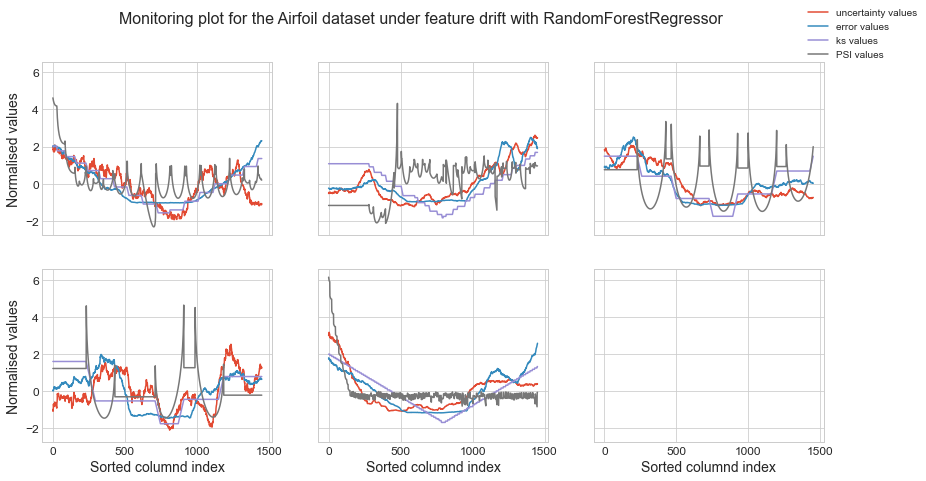

Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.326067  0.389094  0.855979
1       0.701812  0.712955  1.193127
2       0.352981  0.814308  1.027989
3       0.466378  0.403364  0.884234
4       0.316149  0.490139  1.255655
5       0.659919  0.330577  0.938417
6       0.363264  0.332081  0.689135
7       1.006640  0.341547  0.513600
mean    0.524151  0.476758  0.919767


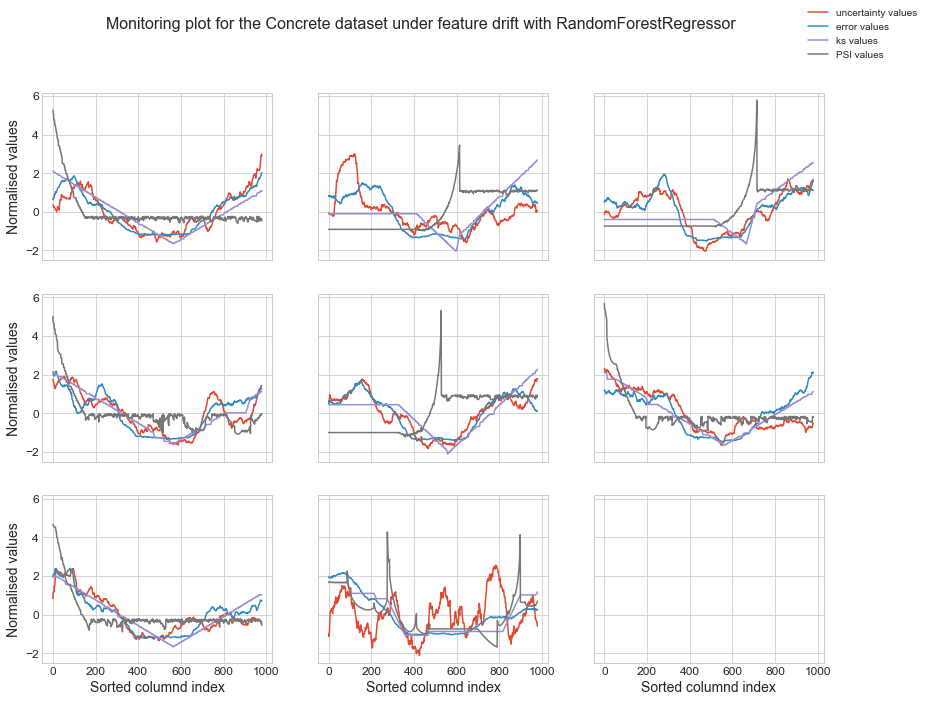

Number of rows 906, 1split 298, 2nd split 608


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.892559  0.306432  0.890276
1       0.987855  0.557312  1.041200
2       0.865090  0.446839  0.945794
3       1.135766  0.913546  0.839902
4       1.188199  0.796380  0.782753
5       0.682936  0.274708  0.760333
mean    0.958734  0.549203  0.876710


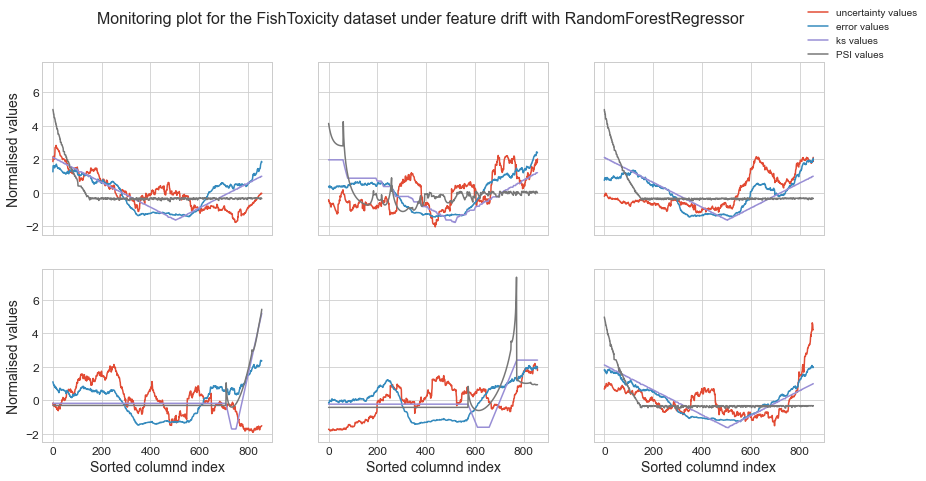

Number of rows 516, 1split 170, 2nd split 346


  0%|          | 0/12 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       1.404306  1.186815  1.123235
1       1.370610  0.913584  0.728264
2       0.451686  1.080712  1.154932
3       0.820328  0.779199  1.109871
4       0.956977  0.752943  0.968814
5       0.186368  1.285478  1.147963
6       0.336248  1.133766  1.038532
7       1.165543  1.111489  1.138921
8       0.904701  1.080148  1.045551
9       1.496170  0.396124  0.485706
10      0.161191  1.386344  1.212906
11      0.739508  0.988413  0.912135
mean    0.832803  1.007918  1.005569


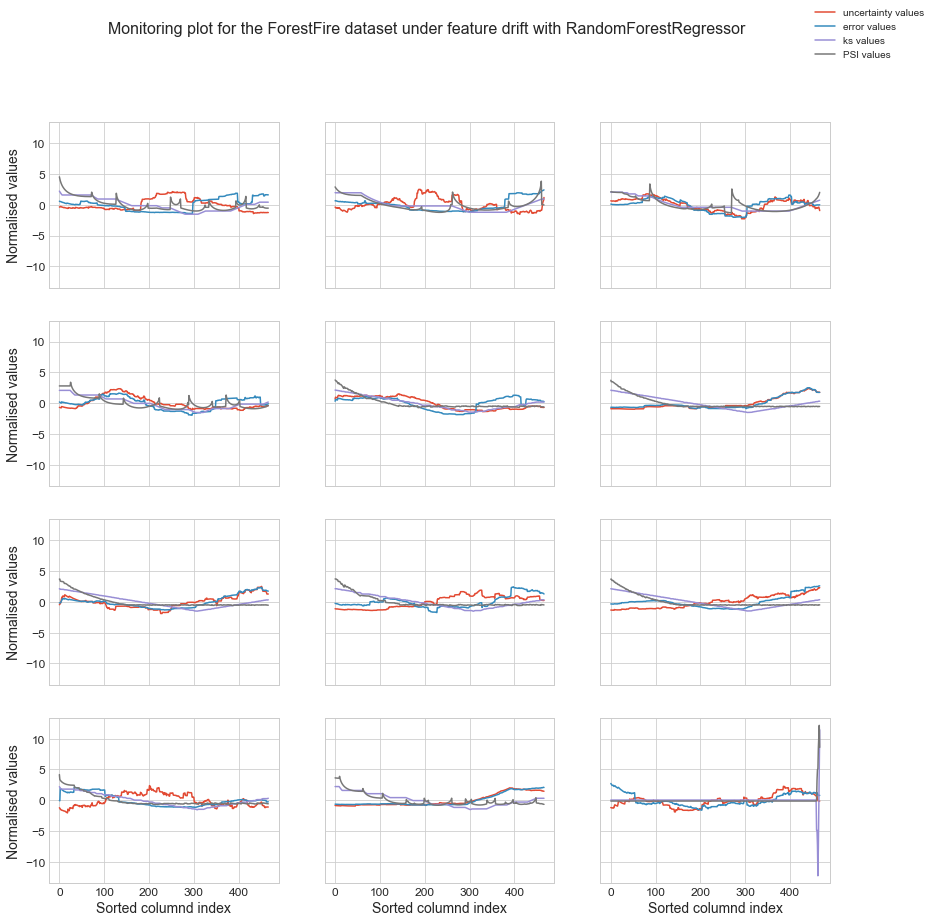

Number of rows 413, 1split 136, 2nd split 277


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.661506  0.883527  0.964528
1       0.380812  0.266006  0.410160
2       0.901448  0.596543  0.680912
3       0.529859  0.568795  0.536570
4       0.900899  0.956107  0.837944
5       0.322994  0.285584  0.329672
mean    0.616253  0.592760  0.626631


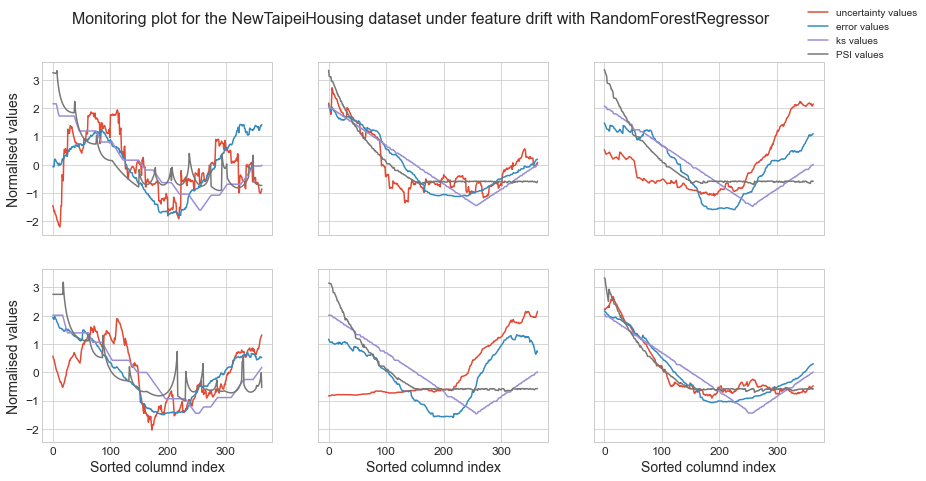

Number of rows 9556, 1split 3153, 2nd split 6403


  0%|          | 0/4 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.473454  0.434615  0.746975
1       0.869825  0.510231  1.036617
2       0.775955  0.380628  0.942862
3       0.691094  0.316791  0.971047
mean    0.702582  0.410566  0.924375


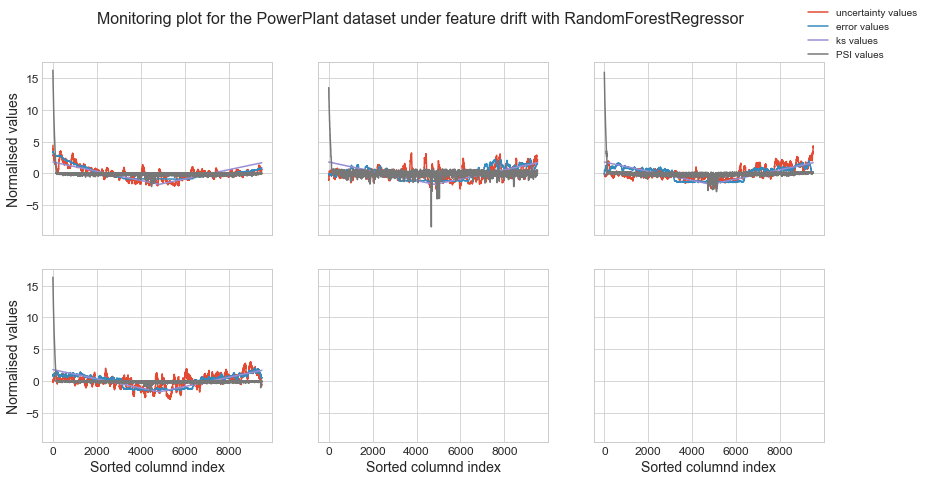

Number of rows 45675, 1split 15072, 2nd split 30603


  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

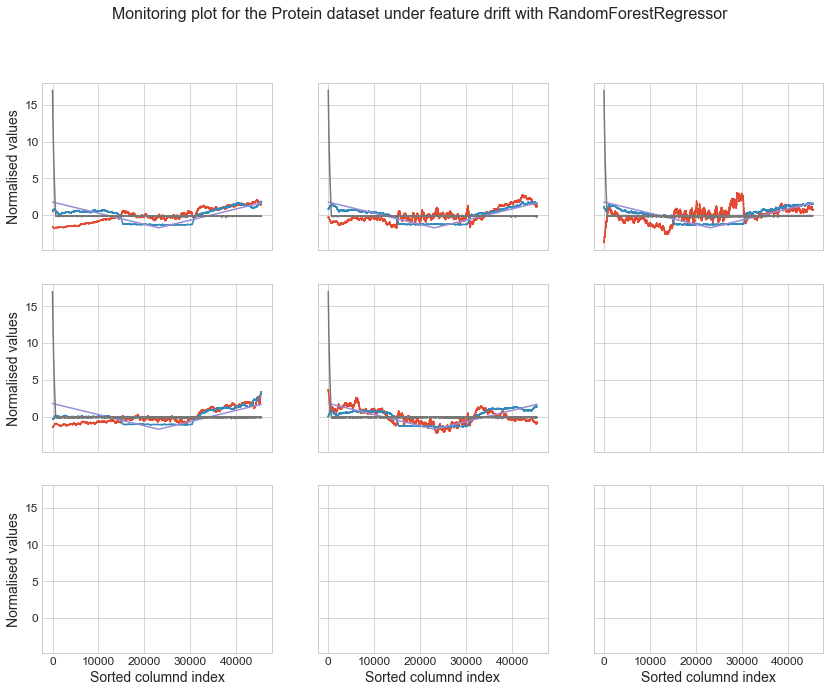

In [11]:
for dataset in dataset_classes:
    monitoring_plot(dataset,RandomForestRegressor,n_estimators = 20)



Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.736890  0.241748  0.720013
1       0.318201  0.583210  1.327465
2       0.410522  0.414918  1.030362
3       0.595891  0.747361  1.239827
4       0.424141  0.370366  0.748444
mean    0.497129  0.471521  1.013222


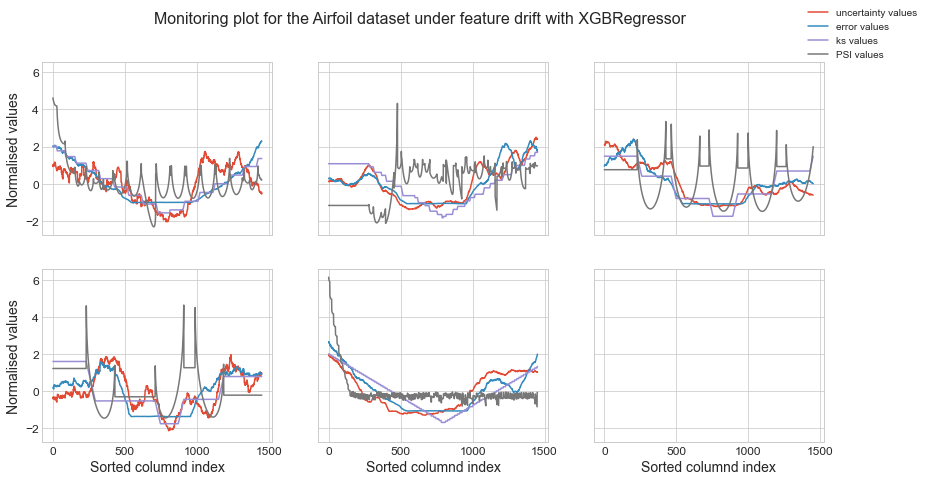

Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.381481  0.332318  0.828074
1       0.586298  0.509665  1.050123
2       0.296958  0.807712  1.008011
3       0.370491  0.318275  0.778244
4       0.365485  0.450897  1.223179
5       0.549754  0.270185  0.886600
6       0.446971  0.302668  0.870011
7       1.182118  0.348497  0.517642
mean    0.522444  0.417527  0.895235


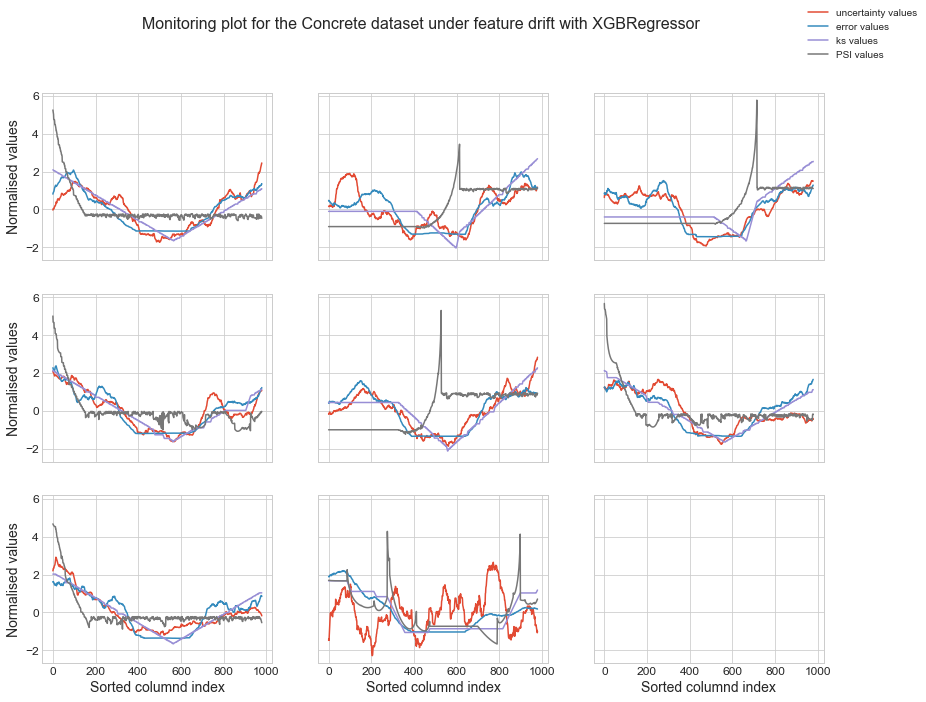

Number of rows 906, 1split 298, 2nd split 608


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.763202  0.359053  0.953777
1       0.739899  0.487207  1.040130
2       0.856445  0.580710  1.097113
3       0.888247  0.989192  0.923902
4       1.362554  0.836882  0.804486
5       0.553073  0.343538  0.855866
mean    0.860570  0.599430  0.945879


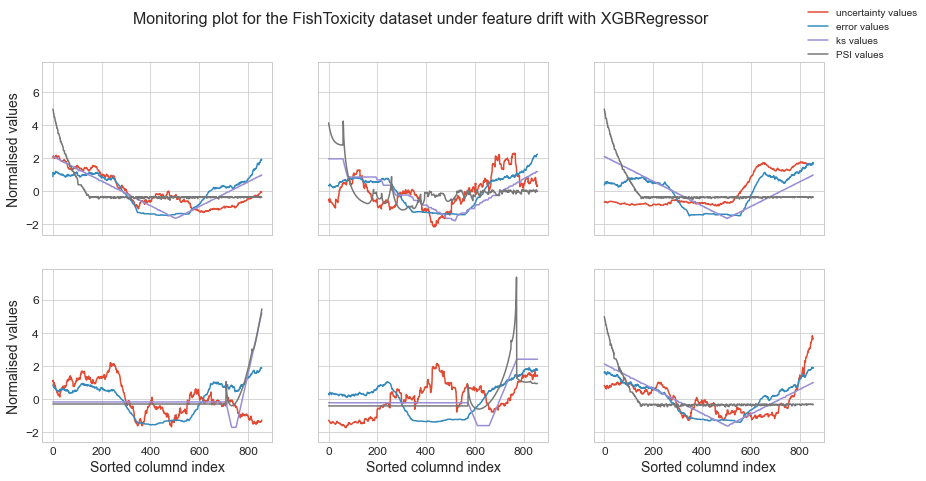

Number of rows 516, 1split 170, 2nd split 346


  0%|          | 0/12 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       1.013764  1.009617  0.962227
1       0.615800  0.905589  0.714773
2       0.937096  1.034678  1.112145
3       1.207670  0.923478  1.092286
4       1.056828  0.828962  0.996107
5       0.382312  1.130026  1.107363
6       0.752764  1.207549  1.121631
7       0.858984  1.001439  1.106371
8       0.750893  1.027251  1.040003
9       0.336717  0.356261  0.473575
10      0.164625  1.334564  1.193566
11      0.647495  0.939583  0.898571
mean    0.727079  0.974916  0.984885


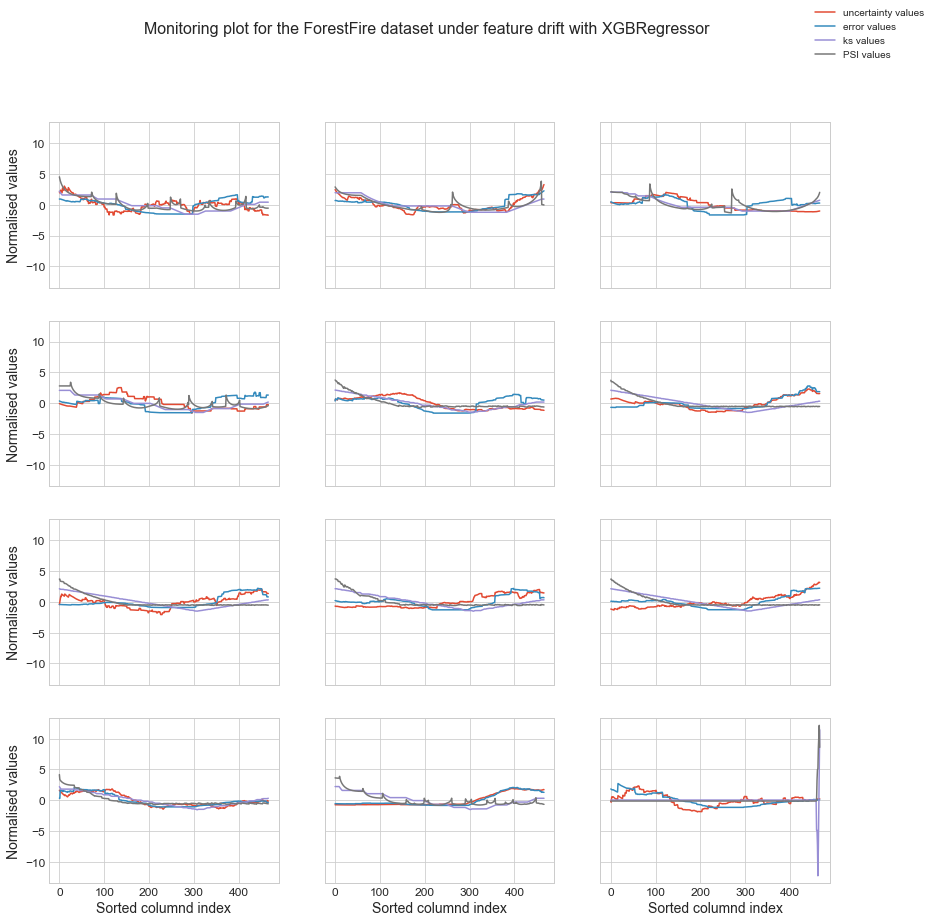

Number of rows 413, 1split 136, 2nd split 277


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.754993  0.947166  0.920750
1       0.227787  0.291834  0.435957
2       1.081130  0.638540  0.718066
3       0.515682  0.729421  0.694694
4       0.446138  1.285787  1.143197
5       0.396007  0.517321  0.607908
mean    0.570289  0.735012  0.753429


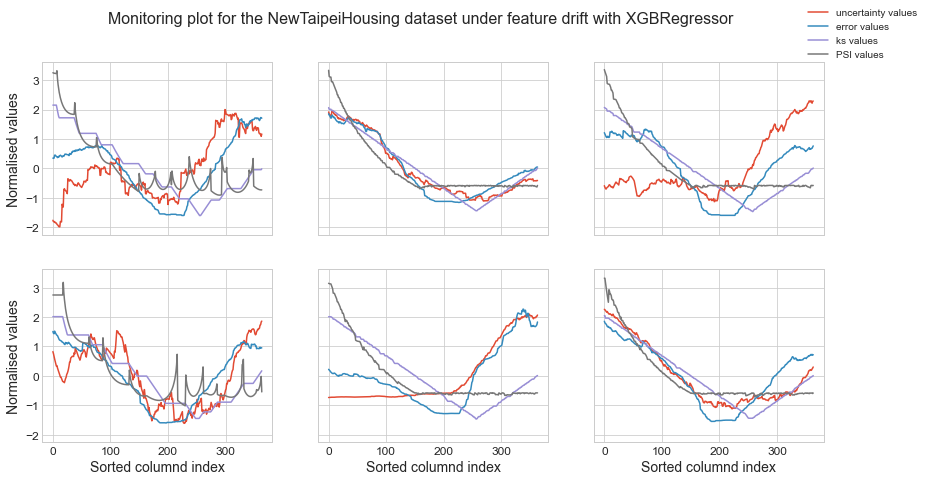

Number of rows 9556, 1split 3153, 2nd split 6403


  0%|          | 0/4 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.473252  0.469514  0.736205
1       0.528619  0.551456  1.036976
2       0.357602  0.417263  0.958050
3       0.314105  0.354274  0.956223
mean    0.418395  0.448127  0.921863


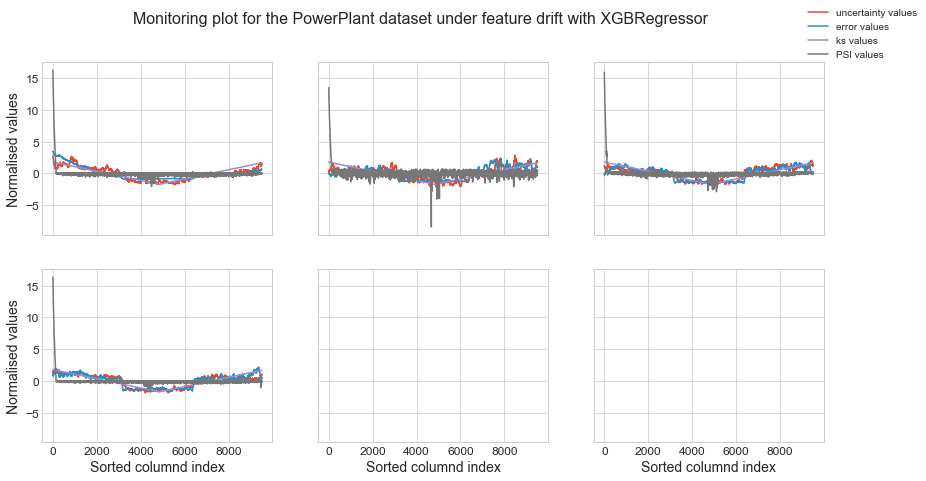

Number of rows 45675, 1split 15072, 2nd split 30603


  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

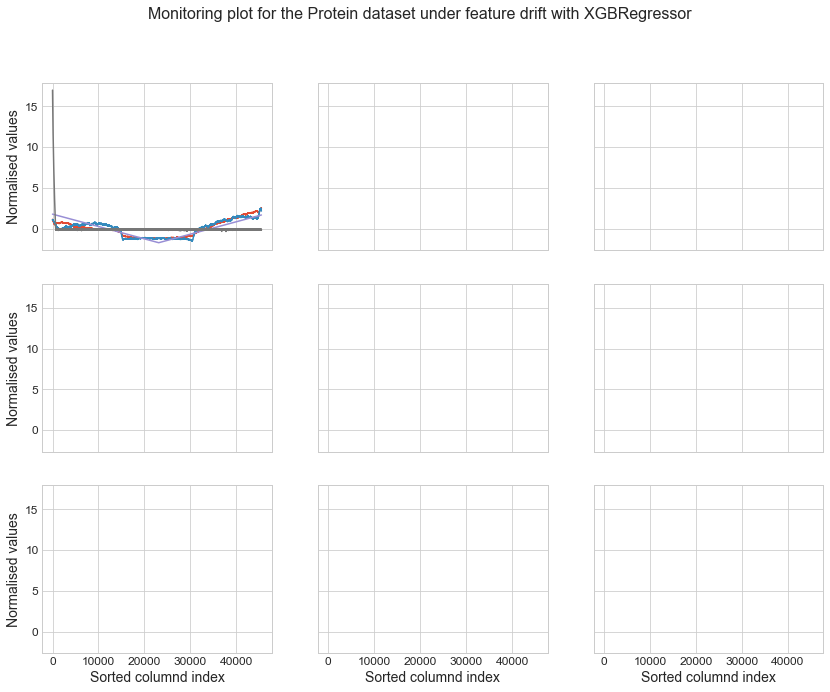

In [12]:
for dataset in dataset_classes:
    monitoring_plot(dataset,XGBRegressor)



Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       1.615011  1.181352  1.142941
1       1.773263  1.209822  0.762624
2       1.625724  1.288940  1.288104
3       1.792552  1.156642  1.369760
4       1.453680  1.049715  1.032766
mean    1.652046  1.177294  1.119239


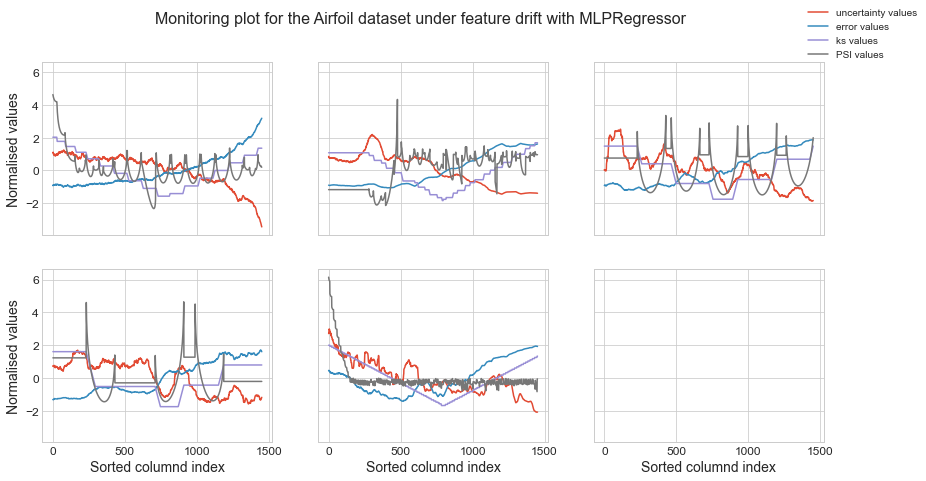

Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.629312  1.174383  1.099424
1       1.459479  0.759764  0.332729
2       1.033160  0.694097  0.637739
3       0.634535  0.533511  0.580406
4       0.685234  1.093057  0.577929
5       0.859568  0.637927  0.813136
6       0.595172  0.594721  0.709462
7       1.165743  0.961516  0.911481
mean    0.882775  0.806122  0.707788


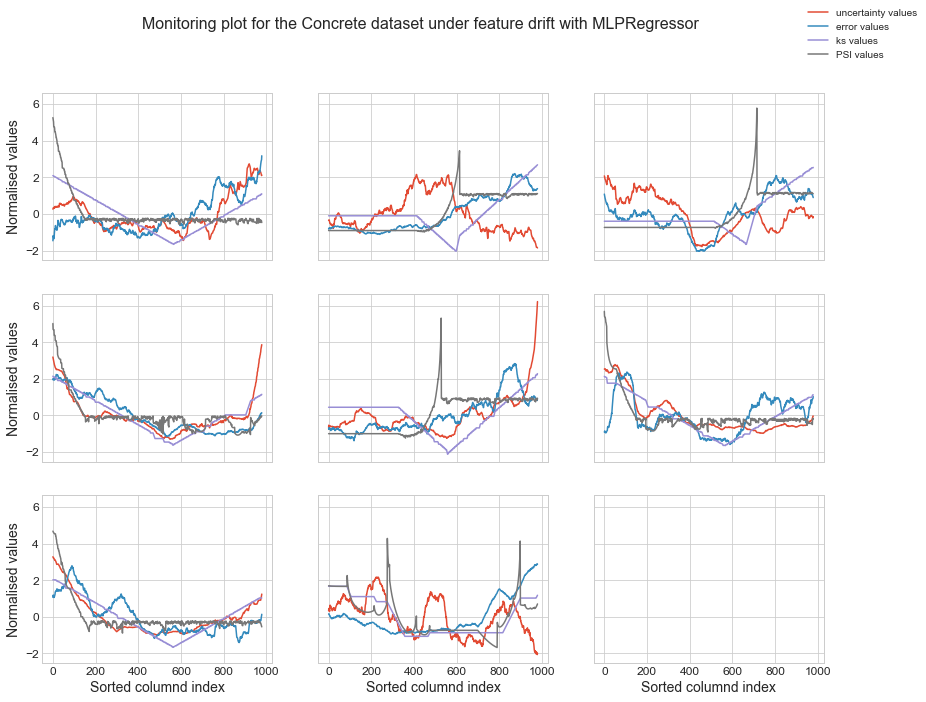

Number of rows 906, 1split 298, 2nd split 608


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.579489  0.803556  0.623727
1       0.533991  1.100922  0.914471
2       0.474669  1.232635  1.177714
3       0.198264  0.419605  0.299437
4       0.118301  0.741840  0.717536
5       0.289179  0.400842  0.425293
mean    0.365649  0.783233  0.693030


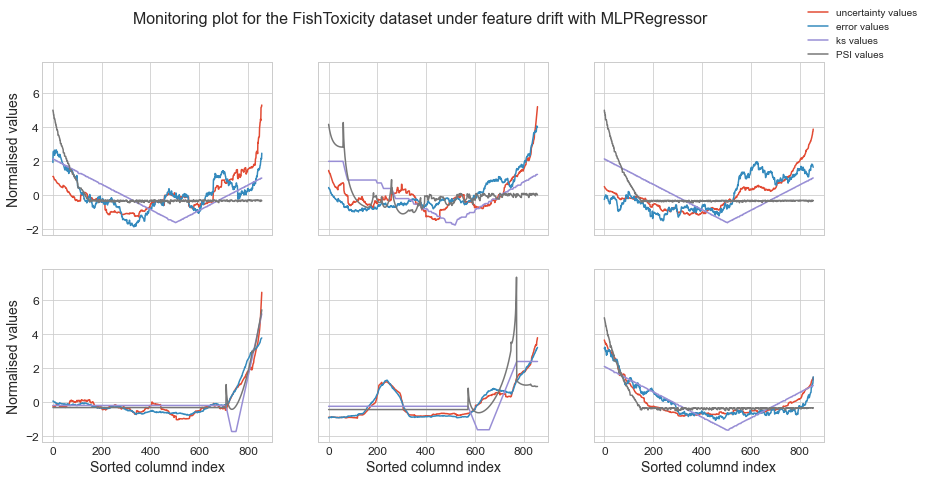

Number of rows 516, 1split 170, 2nd split 346


  0%|          | 0/12 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.984838  1.325912  1.179567
1       1.503093  0.868557  0.728472
2       0.606721  1.526322  1.638508
3       1.151661  1.162922  1.172021
4       0.633068  1.419713  1.280203
5       0.536282  1.564776  1.349338
6       0.617306  1.561259  1.322534
7       0.433450  1.432708  1.299070
8       0.853872  1.461992  1.297493
9       0.562534  0.601723  0.377014
10      0.655092  1.706137  1.372042
11      0.991318  1.008193  0.966826
mean    0.794103  1.303351  1.165257


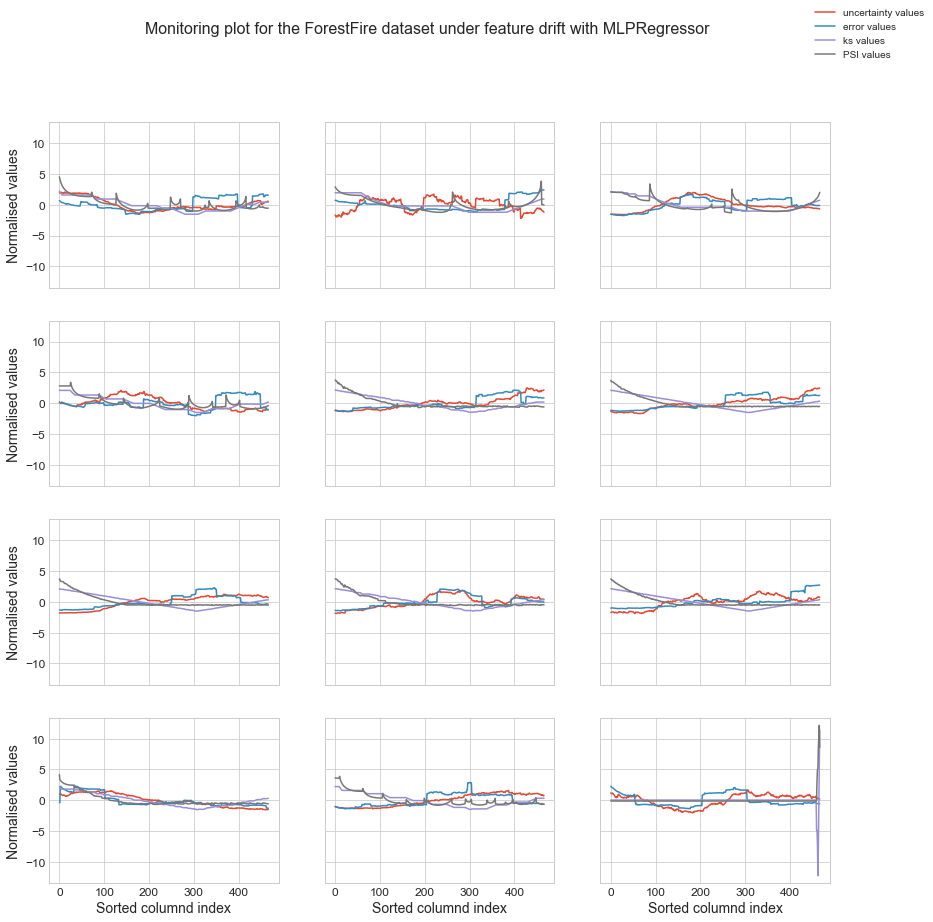

Number of rows 413, 1split 136, 2nd split 277


  0%|          | 0/6 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       1.098122  0.813435  0.668962
1       0.511287  0.244677  0.480421
2       0.432246  0.322565  0.530635
3       0.740108  1.721027  1.555017
4       0.356125  1.658925  1.580890
5       0.854497  1.336489  1.373851
mean    0.665397  1.016186  1.031629


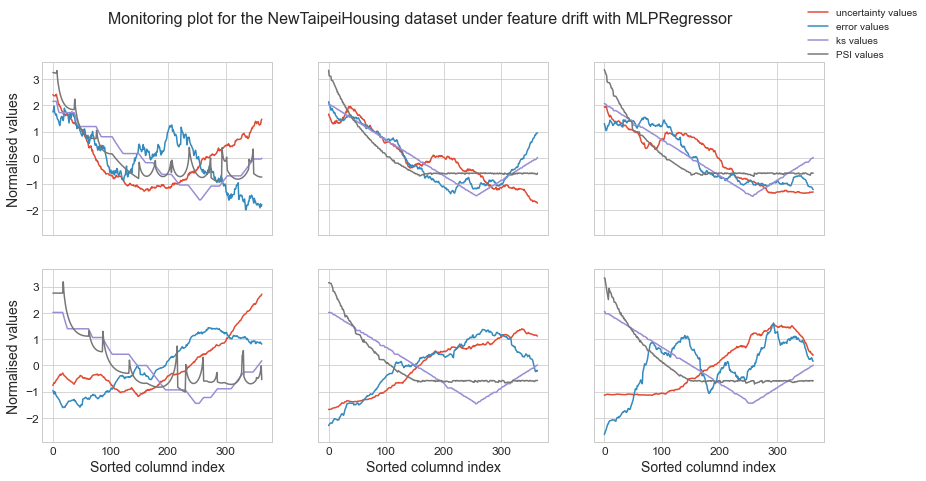

Number of rows 9556, 1split 3153, 2nd split 6403


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset,MLPRegressor)

